# Twitter - DonaldTrump

## Kelly Shaffer, Raphael Nash, Xiaomeng (Vivian) Kong, Michael Muller, Blandon Casenave 

In [2]:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000
import networkx as nx
import pandas as pd
import urllib
import numpy as np
import matplotlib.pyplot as plt 
import sys
import os
from networkx.algorithms import bipartite as bi
#twitter OAUTH 
import time as tm
import json
import argparse as ag
import tweepy as tw
from tweepy.streaming import StreamListener as sl
from tweepy import OAuthHandler as oa
from tweepy import Stream as st
import oauth2 as oauth
import re
import dateutil.parser as dp
from pytz import timezone as tz
import pytz 

In [3]:
CONSUMER_KEY = "vVgMvZu4a5UFuNNmIqLG6kdst"
CONSUMER_SECRET = "SjEZQJIcMjSyP6Tj2blyJsrqfmtsHZmIaJldT0hlbpW4NNx2a3"
ACCESS_KEY = "199763323-wPFrK2QTS9HiMyOnY2yfS1CCCQEGBaS0ZTG0YpfJ"
ACCESS_SECRET = "CPowEv0tAn5Hka5ayCjlGcYl2kecvTJwqiQuSa0OYuF4m"

consumer = oauth.Consumer(key=CONSUMER_KEY, secret=CONSUMER_SECRET)
access_token = oauth.Token(key=ACCESS_KEY, secret=ACCESS_SECRET)
client = oauth.Client(consumer, access_token)

In [4]:
OAUTH_KEYS = {'consumer_key':CONSUMER_KEY, 'consumer_secret':CONSUMER_SECRET,
 'access_token_key':ACCESS_KEY, 'access_token_secret':ACCESS_SECRET}
auth = tw.OAuthHandler(OAUTH_KEYS['consumer_key'], OAUTH_KEYS['consumer_secret'])
api = tw.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [8]:
search = tw.Cursor(api.search, q='#donaldtrump').items(400)

In [9]:
sn = []
text = []
timestamp =[]
for tweet in search:
    print tweet.user.screen_name, tweet.created_at, tweet.text
    timestamp.append(tweet.created_at)
    sn.append(tweet.user.screen_name)
    text.append(tweet.text)

Djamila48_ 2017-07-18 08:44:34 😩🤒🤕#DonaldTrump nuit-il à la #santémentale des #Américains ?  https://t.co/yXAPIZW072 via @MashableFR https://t.co/2TBJS8gCnO
angelaspiby 2017-07-18 08:44:25 #DonaldTrump @realDonaldTrump  hmmmm https://t.co/1iE6GOgcYf
paiglenenab1970 2017-07-18 08:44:06 RT @chuckster6366: #DonaldTrump trump  the grump.  spat his dummy out  cause he never got his way , grow balls trump and listen to the peop…
delanlow 2017-07-18 08:41:45 https://t.co/1Y4lR1cdxF
#Trump #TrumpRussia #GeorgeMichael #wham #MaraLago #ClubTropicana #PoliticalSatire #DonaldTrump #MikePence #Spicer
JHattad 2017-07-18 08:41:40 #DonaldTrump heeft een nieuwe slogan voor #gameofthrones : "Make westeros great again!"😅
aurakpirela 2017-07-18 08:40:25 RT @GegeRpz: #DonaldTrump No pierde tiempo en diplomacia blanda
Dejo a Maduro fuera del Juego Político, hasta con salvoconducto en riesgo.…
rajender725 2017-07-18 08:40:07 RT @nitsnitz: #DonaldTrump offers to be friends with #EmmanuelMacron on #Paris visit

RandPaulizer 2017-07-18 07:40:54 #President #DonaldTrump tells Republican Senators "Just Repeal Failing ObamaCare Now" | #KennyViral News... https://t.co/y3B7NLmtdo
_AgainstTheTide 2017-07-18 07:40:25 #DonaldTrump #StarWars #MelaniaTrump https://t.co/GZGuNfd4Bl
JipeLeloup 2017-07-18 07:38:44 Qd #DonaldTrump vante les mérites du "Made in America" et que son groupe familial fait fabriquer la majorité de ses… https://t.co/rUkJrEHIEa
Nunosc22 2017-07-18 07:38:14 RT @frasesdem3rda: #DonaldTrump #frasesdem3rda https://t.co/5aZwYEosYr
roger_charlatan 2017-07-18 07:38:05 #carpetbaggers #DonaldTrump #IvankaTrump #criminals #LiarInChief #liar https://t.co/phXT7zigp1
CharityZhang1 2017-07-18 07:36:55 RT @betsywilson66: Amen President Trump #mostimportantlywewillbeprotectedbygod #inauguration #trump45 #DonaldTrump #AmericaFirst #buyameric…
BarrEsteven 2017-07-18 07:35:42 RT @gregnisall: #MikePence told students the way to be a leader is to be humble like #DonaldTrump. 🤣😂🤣 Who knew @mike_pence was 

MarcoFanteg 2017-07-18 07:01:55 D'altronde perché i sondaggi dovrebbero buttare bene se hai preso ben TRE milioni di voti in meno di #HillaryClinton, caro #DonaldTrump ?
tinastullracing 2017-07-18 07:01:28 RT @WayneDupreeShow: Thank God the innocent little children don't watch liberal TV cable networks that push hate.

#covfefe #donaldtrump #t…
WendyPeterPan4u 2017-07-18 07:00:50 #DonaldTrump's Doral resort hit with lien for unpaid construction work. THAT MEANS THEY WON IN COURT AGAINST #Trump https://t.co/xQcoKOs4we
haste111 2017-07-18 07:00:19 #FreeBook #Kindle #KindleUnlimited https://t.co/Zo3iDM7wFv
#DonaldTrump https://t.co/Ro3Xe4wIJj
bodgitnscarper 2017-07-18 07:00:12 RT @jurygroup: Would Donald Trump pass the lie detector with Jeremy Kyle? #DonaldTrump @realDonaldTrump #jeremykyle 

RETWEET &amp; VOTE #yourv…
MarkGWomble 2017-07-18 06:59:48 RT @jurygroup: Would Donald Trump pass the lie detector with Jeremy Kyle? #DonaldTrump @realDonaldTrump #jeremykyle 

RETWEET &amp; VOTE #yo

zigm0nd 2017-07-18 06:01:57 RT @jurygroup: Would Donald Trump pass the lie detector with Jeremy Kyle? #DonaldTrump @realDonaldTrump #jeremykyle 

RETWEET &amp; VOTE #yourv…
budgeco 2017-07-18 06:01:21 London won't roll out the red carpet for Donald Trump says Sadiq Khan
https://t.co/Y219vMvvmy via @MailOnline #sadiqkhan #DonaldTrump
DTRUMP_Fans 2017-07-18 06:01:13 Trump Threatens Venezuela With Sanctions - The Atlantic https://t.co/mwYDwTXkB0 #TRUMP #DonaldTrump https://t.co/7uTs230YbV
DonaldTheLiarr 2017-07-18 06:00:33 Let's make the world great again! #trump #donaldtrump #thedonald #president #liar https://t.co/uY7SPToPg4
AntifaOfficial 2017-07-18 05:59:22 minisoc #antifa #fucktrump #feminism #internationalantifa #donaldtrump #communism #socialism https://t.co/c1yBiXxlZC
rafshmatko 2017-07-18 05:57:38 RT @rafshmatko: Nikolai #Shmatko: "#Trump is a structure of the progress. It is even hard to compare him to anyone." #DonaldTrump  https://…
FinancialXpress 2017-07-18 05:57:19 #DonaldT

rafshmatko 2017-07-18 05:37:38 RT @rafshmatko: Nikolai #Shmatko: "His tenure will be successful and his governing reliable" #Trump #DonaldTrump https://t.co/Cqm0fzvpE5 ht…
rafshmatko 2017-07-18 05:36:03 RT @rafshmatko: Welcome! #TRUMP2020 #Trump #DonaldTrump https://t.co/lsoOR0IRx7
drumpfshit360 2017-07-18 05:36:02 https://t.co/Erbfff1htL #trump #MAGA #crookedhillary #lockherup #trumptrain #deplorables #americafirst #buildthewall #USA #donaldtrump dnj
rafshmatko 2017-07-18 05:35:58 RT @rafshmatko: #Trump is my choice, not #Russia's! #DonaldTrump #TrumpTrain #MAGA #TrumpisMyChoice https://t.co/5bJmTrmUQx
rafshmatko 2017-07-18 05:35:53 RT @rafshmatko: https://t.co/aeqQOYPNqz Now some #pictures with #Trump makes #teespring! #USA #CanvasPrint #print #DonaldTrump – TRUMP #MAG…
rafshmatko 2017-07-18 05:35:48 RT @rafshmatko: https://t.co/DoiAYd04Uh Now some #pictures with #Trump makes #teespring! #USA #CanvasPrint #print #DonaldTrump – TRUMP #MAG…
rafshmatko 2017-07-18 05:35:44 RT @rafshmatko

freethnker2 2017-07-18 05:06:34 RT @rafshmatko: The #legendary bust of #DonaldTrump – as a symbol and herald of his complete victory. A sponsor is required for an #exhibit…
KnowYourLeaker 2017-07-18 05:06:15 Ex Black Panther Leader: Trump Is Pro-police Brutality (pls RT↺❤️) ️️ https://t.co/XQEWeV194G #DonaldTrump #BillClinto
Hellqvisttri 2017-07-18 05:04:56 Translation: take away health care from millions of Americans and hope for the best...

#DonaldTrump
#Healthcare https://t.co/9AylrAN1nW
citizenkane61 2017-07-18 05:04:07 @politico @JoeNBC @HuffPost @CNN @AP It appears #MitchMcConnell has declared war on poor people. God bless them one… https://t.co/YVgTf3Szsy
gransalamandra 2017-07-18 05:03:26 Theresa May is a master of diplomacy. Chances are by 2018 #DonaldTrump may not be @POTUS anymore. https://t.co/Tirby85XOE
TrumpEra_2017 2017-07-18 05:03:25 "A Classic State Capitalist": How Donald Trump Profited from Public Subsidies &amp; Political Favors
#DonaldTrump 
https://t.co/xXX7pfrdD

jasminejoness 2017-07-18 04:05:56 I know for certain that I would be a better president than #DonaldTrump
johnnyhosg 2017-07-18 04:05:54 https://t.co/3JPhytlTJH #DonaldTrump #TrumpJr #Democrats #Republicans #usa #Russophobia #Moscow #AsiaPacific
MikeJackson9701 2017-07-18 04:05:10 RT @WayneDupreeShow: Thank God the innocent little children don't watch liberal TV cable networks that push hate.

#covfefe #donaldtrump #t…
josefelixmena 2017-07-18 04:03:50 RT @GegeRpz: #DonaldTrump No pierde tiempo en diplomacia blanda
Dejo a Maduro fuera del Juego Político, hasta con salvoconducto en riesgo.…
lshafran 2017-07-18 04:02:19 #MADEINAMERICAWEEK start with yourself and your daughter #DonaldTrump #IvankaTrump https://t.co/R9dWPjJM5J
jackflackdaily 2017-07-18 04:02:01 Dr. Alveda King: Trump Is Leading Civil Rights for Unborn https://t.co/if9WVxxsRB #trump #maga #deplorables… https://t.co/nySWTuuqvv
wallrad 2017-07-18 04:00:25 RT @jurygroup: Would Donald Trump pass the lie detector with Jeremy Kyl

In [20]:

# Convert lists to dataframe
df = pd.DataFrame()
df['timestamp'] = timestamp
df['sn'] = sn
df['text'] = text

In [21]:
# Prepare ford date filtering. Adding an EST time column since chat hosted by people in that time zone.
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['EST'] = df['timestamp'] - pd.Timedelta(hours=5) #Convert to EST

In [22]:
df['EST'] = pd.to_datetime(df['EST'])

In [9]:
#Subset for the dates required. Can select a specific date or time to examine.
#df = df[(pd.to_datetime("2017-7-14 20:00:00", format='%Y-%m-%d %H:%M:%S') < df['EST']) & (df['EST'] < pd.to_datetime("2017-7-14 21:00:00", format='%Y-%m-%d %H:%M:%S'))]

In [23]:
# adjust local path.
df.to_csv('/Users/digitalmarketer1977/Desktop/620trumptweets.csv',index = False,encoding='utf-8')

In [24]:
# Create a list of the unique usernames in order to see which users we need to retrieve friends for.
allNames = list(df['sn'].unique())

In [25]:
# Initialize dataframe of users that will hold the edge relationships
dfUsers = pd.DataFrame()
dfUsers['userFromName'] =[]
dfUsers['userFromId'] =[]
dfUsers['userToId'] = []
count = 0 

In [31]:
nameCount = len(allNames)
# The choice to retrieve friends (who the user is following) rather than followers is intentional.
# Either would work. However, many Twitter users follow fewer users than are following them, especially the most popular accounts. 
# This reduces the number of very large calls to Twitter API, which seemed to cause problems.
for name in allNames:
    # Build list of friends    
    currentFriends = []
    for page in tw.Cursor(api.friends_ids, screen_name=name).pages():
        currentFriends.extend(page)
    currentId = api.get_user(screen_name=name).id
    currentId = [currentId] * len(currentFriends)
    currentName = [name] * len(currentFriends)   
    dfTemp = pd.DataFrame()
    dfTemp['userFromName'] = currentName
    dfTemp['userFromId'] = currentId
    dfTemp['userToId'] = currentFriends
    dfUsers = pd.concat([dfUsers,dfTemp])
    tm.sleep(5) # avoids hitting Twitter rate limit
    # Progress bar to track approximate progress
    count +=1
    per = round(count*100.0/nameCount,1)
    sys.stdout.write("\rTwitter call %s%% complete." % per)
    sys.stdout.flush() 

Rate limit reached. Sleeping for: 237
Twitter call 5.1% complete.Rate limit reached. Sleeping for: 817


KeyboardInterrupt: 

In [32]:
dfUsers[:20]

,userFromName,userFromId,userToId
0,Djamila48_,483398029.0,8.011597e+17
1,Djamila48_,483398029.0,2.298251e+08
2,Djamila48_,483398029.0,1.115564e+08
3,Djamila48_,483398029.0,8.714189e+17
4,Djamila48_,483398029.0,4.728523e+08
5,Djamila48_,483398029.0,7.659572e+17
6,Djamila48_,483398029.0,1.262841e+08
7,Djamila48_,483398029.0,1.060486e+08
8,Djamila48_,483398029.0,1.192916e+09
9,Djamila48_,483398029.0,1.005342e+09


In [33]:
# Again, to limit the number of calls to Twitter API, just do lookups on followers that connect to those in our user group.
# We are not interested in "friends" that are not part of this community.
fromId = dfUsers['userFromId'].unique()
dfChat = dfUsers[dfUsers['userToId'].apply(lambda x: x in fromId)]

In [34]:
# No more Twitter API lookups are necessary. Create a lookup table that we will use to get the verify the userToName
dfLookup = dfChat[['userFromName','userFromId']]
dfLookup = dfLookup.drop_duplicates()
dfLookup.columns = ['userToName','userToId']
#dfCommunity = pd.DataFrame()
#dfCommunity = pd.merge(dfLookup, on='userToId')

In [ ]:
#dfLookup

In [ ]:
#dfLookup.to_csv('dfLookup.csv',index = False,encoding='utf-8')

In [ ]:
#dfGraph = pd.read_csv('dfLookup.csv')

In [ ]:
#dfGraph = dfGraph[index]

In [35]:
G = nx.DiGraph()
#G = nx.Graph()
G.add_nodes_from(dfUsers['userFromId'])
#G.add_edges_from(zip(df['userFromId'],df['userToId']))

In [36]:
temp = zip(dfUsers['userFromId'],dfUsers['userToId'])
G.add_edges_from(temp)

In [ ]:
# Give nodes their Usernames
#dfLookup = df[['userFromName','userFromId']].drop_duplicates()

In [37]:
dfUsers.head()
for userId in dfUsers['userFromId']:
    temp = dfUsers['userFromName'][dfUsers['userFromId']==userId]
    G.node[userId]['userName'] = temp.values[0]

In [38]:
G.add_path([0,1,2,3,4])
H = G.subgraph([0,1,2,3,4])
H.edges()

[(0, 1), (1, 2), (2, 3), (3, 4)]

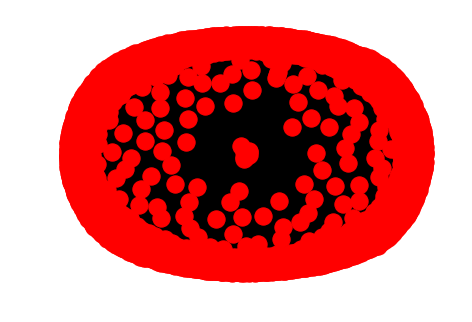

In [43]:
nx.draw(G, pos=nx.spring_layout(G))
plt.show()

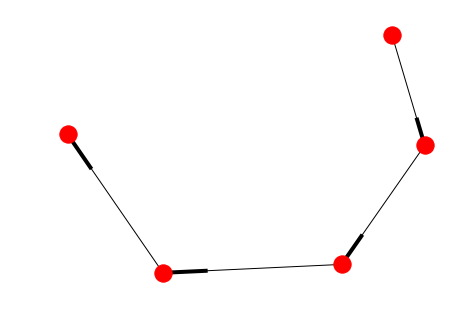

In [44]:
nx.draw(H, pos=nx.spring_layout(H))
plt.show()

## Code Sources

[https://stackoverflow.com/questions/6399978/getting-started-with-twitter-oauth2-python](Getting started with Twitter\OAuth2\Python)

[http://www.techpoweredmath.com/constructing-social-graph-twitter-plotly/#.WWuUx9MrKYW](Constructing a Social Graph With Twitter and Plotly)